# Simulating Stock

This notebook details the process of creating a simulated dataset.

This simulation models a distribution warehouse that acts as an intermediary between a large supplier and the end customer. 

The warehouse:

- Purchases shipments in bulk from an upstream supplier.
- Stores and manages the stock.
- Fulfills customer orders through daily outbound deliveries.
- Aims to balance utilization and delivery efficiency while keeping costs low.

The simulation explores different stock replenishment strategies (scheduled vs. Just-in-Time) and tracks key perfomance metrics such as stock levels, unmet demand and shipment volumes. This reflects a common B2C logistics model where warehouses play critical roles in order fulfilment. 

Import the required modules:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats


## Basic set-up

Define the period of the simulation (1 Quarter/90 days):

In [2]:
start_date = pd.to_datetime("2024-01-01")
dates = pd.date_range(start_date, periods=90)
df_dates = pd.DataFrame({"date": dates})

Define the products to be sold from warehouse:

In [3]:
product_ids = [f"P{str(i).zfill(3)}" for i in range(1, 16)]
df_products = pd.DataFrame({"product_id": product_ids})

Cross join the two dataframes to get every combination of products and date:

In [4]:
df = df_dates.merge(df_products, how="cross")

For simplicity, we will have one warehouse initially:

In [5]:
df["warehouse_id"] = "WH1"

Initialize inbound units to zero:

In [6]:
df["inbound_units"] = 0

Classify each product by how quickly it sells. The products that sell quickly are assigned lower product numbers:

In [7]:
fast_movers = product_ids[0:5]
medium_movers = product_ids[5:10]
slow_movers = product_ids[10:]

This method of classification resembles a simplified **ABC analysis** framework.

In such a framework, goods that are expected to provide the majority of the revenue, the fast movers, are assigned to **class A**. These goods require the most frequent restocking. Goods with a moderate demand and contribute a moderate amount of revenue are classified as **class B**. In our simulation, these are the medium movers. Finally, **class C** goods are either low-value or infrequently ordered, these are represented by the slow movers.

## Outbound demand
Simulate orders for each product. Every day, there will be a random number of items ordered for each product.

We can use different probability distributions to model different behaviours of base demand.

- **Fast movers** (Class A) - Normal distribution (high and consistent demand).
- **Medium movers** (Class B) - Poisson distribution (steady but lower demand). 
- **Slow movers** (Class C) - Negative binomial distribution (low and erratic demand).

In [8]:
def assign_group(row):
    product_id = row["product_id"]
    if product_id in fast_movers:
        return "A"
    elif product_id in medium_movers:
        return "B"
    else:
        return "C"

In [9]:
df["class"] = df.apply(assign_group, axis=1)

For more variable demand, we can also modify the underlying base demand by adding noise with an additional normal distribution. 

Additionally, we can also add a chance of demand spikes and dips, and variation given the date. This will challenge demand forecasting based on the weekly moving average.

First generate demand multiplier from the <code>date</code> column:

In [10]:
def date_based_demand(date):
    day = date.day
    if day <= 7:
    # higher demand at the start of the month
        return np.random.normal(1.2, 0.05)
    elif day >= 22:
    # lower demand at the end of the month
        return np.random.normal(0.7, 0.05)
    else:
        return 1

Use the date function in the larger <code>simulate_demand</code> function:

In [11]:
def simulate_demand(row):
    product_id = row["product_id"]
    date_multiplier = date_based_demand(row["date"])
    
    
    # There is a chance to have a larger or smaller demand than normal
    event_chance = np.random.rand()

    if event_chance > 0.9:
        demand_multiplier = 1.2
    elif event_chance < 0.1:
        demand_multiplier = 0.7
    else:
        demand_multiplier = 1

    # simulate the demand using relevant distributions 
    if product_id in fast_movers:
        base_demand = np.random.normal(loc=25, scale=5)
        fluct_scale = 5
    elif product_id in medium_movers:
        base_demand = np.random.poisson(lam=9)
        fluct_scale = 3
    else:
        base_demand = stats.nbinom.rvs(n=2, p=0.3)
        fluct_scale = 1

    # simulate random flucuations each day
    fluctuation = np.random.normal(loc=0, scale=fluct_scale)
    demand = int(max(0, base_demand * demand_multiplier * date_multiplier + fluctuation))

    return demand


In [12]:
df["demand"] = df.apply(simulate_demand, axis=1)

Initialize the <code>actual_outbound</code> column to be equal to the demand.

In [13]:
df["actual_outbound"] = df["demand"]

## Inbound stock
Next, we need to model deliveries from the supplier to replenish the warehouse inventory.

There are different stock replenishment strategies that vary on how often and how much stock is replinished in each cycle.

In [14]:
def simulate_inventory(group, policy="weekly", lead_time=3):

    group = group.copy()

    # Establish starting stock (buffer stock) based on ABC classification
    item_class = group["class"].iloc[0]
    starting_stock_dict = {"A": 200, "B": 75, "C": 35}
    inventory = starting_stock_dict.get(item_class)
    reorder_point = starting_stock_dict.get(item_class) * 0.4

    # Initialize empty lists
    inventory_list = []
    actual_outbound_list = []
    inbound_list = []
    pending_orders = [] # contains tuples with date and quantity
    stockout_list = []

    # Calculate the seven-day rolling average for demand
    group["seven_day_average"] = group["demand"].shift(1).rolling(window=7, min_periods=1).mean().round()

    # iterate through the group
    for index, row in group.iterrows():
        
        date = row["date"]
        demand = row["demand"]
        rolling_average = row["seven_day_average"]

        # 1. apply inbound orders in the inbound orders list if date matches
        arrivals_today = [q for (d, q) in pending_orders if d == date]
        inbound_today = sum(arrivals_today)
        inventory += inbound_today
        pending_orders = [(d, q) for (d, q) in pending_orders if d != date]

        # 2. ship out orders equal to demand
        actual_outbound = min(demand, inventory)
        inventory -= actual_outbound

        # prevent multiple orders when an order is inbound
        has_pending_order = any(d > date for (d, _) in pending_orders)

        # 3. replenishment logic
        if  policy == "JIT":
        # Every day check if stock is below 
            if inventory < reorder_point and not has_pending_order:
                delivery_date = date + pd.Timedelta(days=lead_time)
                pending_orders.append((delivery_date, starting_stock_dict.get(item_class)))

        elif policy == "weekly" and date.dayofweek == 4:
            # uses the rolling average for the week
            if rolling_average and not pd.isna(rolling_average):
                delivery_quantity = 7 * int(rolling_average)
                delivery_date = date + pd.Timedelta(days=lead_time)
                # avoid over-stocking
                if inventory < (1.5 * delivery_quantity):
                    pending_orders.append((delivery_date, delivery_quantity))

        inventory_list.append(inventory)
        actual_outbound_list.append(actual_outbound)
        inbound_list.append(inbound_today)
        stockout_list.append(actual_outbound < demand)
            
                
    group["inventory_level"] = inventory_list
    group["actual_outbound"] = actual_outbound_list
    group["inbound_units"] = inbound_list
    group["stockout_flag"] = stockout_list
    group["unmet_demand"] = group["demand"] - group["actual_outbound"]

    return group

In [15]:
weekly_df = df.groupby(['product_id', 'warehouse_id'], group_keys=False).apply(simulate_inventory)

In [16]:
jit_df = df.groupby(['product_id', 'warehouse_id'], group_keys=False).apply(simulate_inventory, policy="JIT")

Lead time.

In [24]:
weekly_df.groupby("product_id").agg({"demand": "sum", "actual_outbound": "sum", "inventory_level": ["max", "min"]})

demand actual_outbound inventory_level    
              sum             sum             max min
product_id                                           
P001         2033            2016             264   0
P002         2102            1971             269   0
P003         2097            2097             219  15
P004         2000            1984             228   0
P005         2149            2037             298   0
P006          669             669              74   4
P007          783             748             135   0
P008          766             723              93   0
P009          776             724             105   0
P010          642             583              88   0
P011          372             335              73   0
P012          402             337              52   0
P013          338             306              50   0
P014          341             312              52   0
P015          461             427              74   0

In [25]:
jit_df.groupby("product_id").agg({"demand": "sum", "actual_outbound": "sum", "inventory_level": ["max", "min"]})

demand actual_outbound inventory_level    
              sum             sum             max min
product_id                                           
P001         2033            2033             237  12
P002         2102            2083             219   0
P003         2097            2072             219   0
P004         2000            1990             230   0
P005         2149            2128             218   0
P006          669             669              83   0
P007          783             774              83   0
P008          766             746              92   0
P009          776             749              85   0
P010          642             642              91   4
P011          372             330              46   0
P012          402             366              41   0
P013          338             304              46   0
P014          341             331              44   0
P015          461             418              43   0

In [19]:
df_test = weekly_df[weekly_df["product_id"] == "P003"]

In [20]:
df_test_2 = jit_df[jit_df["product_id"] == "P003"]

array([[<Axes: title={'center': 'demand'}>]], dtype=object)

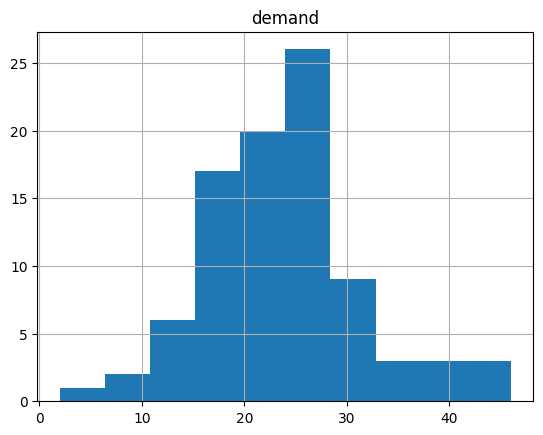

In [21]:
df_test.hist("demand")

In [22]:
df_test.to_csv("test.csv", index=False)

In [23]:
df_test_2.to_csv("test_2.csv", index=False)